# Homework 3

**Link to the viewer for proper map rendering**: [HERE](https://nbviewer.jupyter.org/github/ChristianMct/ADA2017-Homeworks/blob/master/03%20-%20Interactive%20Viz/hw3.ipynb)

In this homework, we use choropleth maps in order to study the unemployement rates in Europe and in Switzerland. At each step, we discuss the choice of colors and the vizualisation parameters.

The notebook is organized as follow:

* **Task 1: Europe**
* **Task 2 and 3: Switzerland **
* **Task 4: Röstigraben**

We start by importing the required packages.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import folium
import matplotlib.pyplot as pp

%matplotlib inline

# Task 1: Europe

## Data extracting, formatting and completing

First, we load the excel file that was previously downloaded from the eurostat website. The latter contains the unemployment rate of european countries in July 2017, the most recent month for which we have a rate for each country. Note that we already preprocessed the data by removing useless columns and rows from the ```.xls``` file, and by correcting the name of Germany.

Also, we add a country ID to the previous dataframe because it is easier to use in the choropleth function for the "key_on" identifier. We do it by hand relating IDs from the topojson file with the country names from the dataframe, it is fine to do so as we have less than 30 countries.

Lastly, we manually add a value for Switzerland because it is absent from the eurostat dataset. The value was taken from the amstat dataset.

In [2]:
df=pd.read_excel('eurostat.xlsx')
df['rate'] = pd.to_numeric(df['rate'],errors=False)

country_to_id = {
"Belgium": "BE",
"Bulgaria": "BG",
"Czech Republic": "CZ",
"Denmark": "DK",
"Germany": "DE",
"Estonia": "EE",
"Ireland": "IE",
"Greece": "GR",
"Spain": "ES",
"France": "FR",
"Croatia": "HR",
"Italy": "IT",
"Cyprus": "CY",
"Latvia": "LV",
"Lithuania": "LT",
"Luxembourg": "LU",
"Hungary": "HU",
"Malta": "MT",
"Netherlands": "NL",
"Austria": "AT",
"Poland": "PL",
"Portugal": "PT",
"Romania": "RO",
"Slovenia": "SI",
"Slovakia": "SK",
"Finland": "FI",
"Sweden": "SE",
"United Kingdom": "GB",
"Iceland": "IS",
"Norway": "NO",
"Turkey": "TR"
}
df["country_id"] = df["country"].map(country_to_id)

df.loc[len(df)]=["Switzerland", 3, "CH"]

df

,country,rate,country_id
0,Belgium,7.5,BE
1,Bulgaria,5.9,BG
2,Czech Republic,2.9,CZ
3,Denmark,5.7,DK
4,Germany,3.6,DE
5,Estonia,5.8,EE
6,Ireland,6.6,IE
7,Greece,20.1,GR
8,Spain,16.3,ES
9,France,9.1,FR


## Choice of the colors and visualization parameters

In order to choose the colouring threshold for the choropleth map, we looked at some dataframe stats. Initially, we chose to place the threshold at the rate values corresponding to 25%, 50% and 75% of the european countries. However, we noticed that using such thresholds, some countries with very similar unemployment rates might have drastically different colours. Hence, we decided to plot the different rates and to place thresholds in between visible clusters. 

While trying to formalize that approach using a K-mean algorithm, we came to learn about the [Jenks natural breaks optimization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) method, an algorithmic solution designed for this specific problem. Roughly, the basic principle is to find the cut that maximimizes the distance between groups' means (so that country appearing in different colors are really different) while at the same time minimizing the variance within groups (so that countries in the same color can be seen as similar). Unfortunately, we argue that this method still produce quite "unfair" comparisons between data points (or the implementation we found were not correct).

We finally decided that, for the scope of this homework, manual assignment of the threshold was a viable strategy, and had the advantage of being justifiable. For instance, as we are asked to compare Switzerland against other countries, it makes sense to have finer granularity around its rate value.

We therefor define the ```plot_groups``` function to help us set and understand the threshold values.

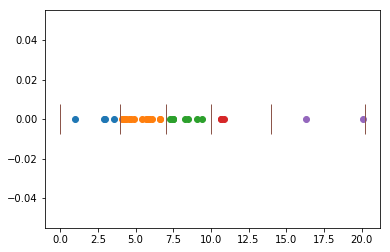

In [3]:
def plot_groups(df, col, breaks):
    for i in range(len(breaks)-1):
        points = df[df[col].between(breaks[i], breaks[i+1])][col]
        pp.plot(points, np.zeros_like(points), 'o')
    
    pp.plot(breaks, np.zeros_like(breaks), '|', markersize=30)
    pp.show()

breaks = [0, 4, 7,  10, 14, 20.2]
plot_groups(df, "rate", breaks)

## Europe's unemployment rate Map (2016)

Finally, we construct the choropleth map showing the unemployment rate in 2016 in Europe using the thresholds. Choice on the color-palette is not discussed as it would mainly be influenced by the targeted audiance of the vizualization.

In [4]:
geo_json_data = json.load(open('topojson/europe.topojson.json'))

# Keep only geometries for country we know the data
geo_json_data["objects"]["europe"]["geometries"] = [g for g in geo_json_data["objects"]["europe"]["geometries"] if g["id"] in list(df["country_id"])]

m_europe=folium.Map([52.5,15], tiles='cartodbpositron', zoom_start=4)
m_europe.choropleth(geo_data= geo_json_data, topojson='objects.europe', 
                    key_on='id',
                    data=df, columns=['country_id','rate'],
                    threshold_scale = breaks,
                    fill_color='OrRd',
                    #fill_opacity=0.7, 
                    #line_opacity=0.2,
                   legend_name= 'Unemployment rate in July 2016 in Europe (%)')

display(m_europe)
print("Choropleth map of the unemployment rates in Europe. ")

Choropleth map of the unemployment rates in Europe. 


## Comparison of Switzerland's unemployment rate with the rest of Europe

Switzerland has a 3% unemployment rate which is very low compared to the rest of Europe, it is in 25% of countries with lowest rate in July 2017.

# Task 2 and 3: Switzerland

## Data extracting, formatting and completing

For the amstat dataset, unemployment rates per canton can only be exported grouped by nationality (Swiss vs foreigners) OR age group OR not grouped at all. We chose to work from 3 different exports (one per grouping option), so that we don't have to transform the rates ourself because it would require additional sources of data (including the active population count per canton).

Again, we map the cantons to their respective codes manually, as there is only 26 of them.

Finally, we extend the ungrouped DataFrame with the rate difference between the *Swiss* and the *foreigners* groupes to help us answer question 3. Note that because the former is always smaller than the latter, we do not need to use absolute value difference.

In [5]:
cant_to_id = {
    "Berne": "BE",
    "Soleure": "SO",
    "Argovie": "AG",
    "Bâle-Campagne": "BL",
    "Bâle-Ville": "BS",
    "Appenzell Rhodes-Extérieures": "AR",
    "Appenzell Rhodes-Intérieures": "AI",
    "Glaris": "GL",
    "Grisons": "GR",
    "Schaffhouse": "SH",
    "St-Gall": "SG",
    "Thurgovie": "TG",
    "Lucerne": "LU",
    "Nidwald": "NW",
    "Obwald":"OW",
    "Schwyz": "SZ",
    "Uri": "UR",
    "Zoug": "ZG",
    "Zurich": "ZH",
    "Fribourg":"FR",
    "Jura":"JU",
    "Neuchâtel": "NE",
    "Genève": "GE",
    "Valais": "VS",
    "Vaud": "VD",
    "Tessin": "TI"
}

files = ("amstat_all.xlsx", "amstat_nat.xlsx", "amstat_age.xlsx")

num_fields = ("rate", "unempl_c", "jobseek_c", "empl_jobseek_c")

def get_data_from_xlsx(file):
    df = pd.read_excel(file)
    df["cant_id"] = df["cant"].map(cant_to_id)
    df.set_index(list(filter(lambda col: col not in num_fields, df.columns.values)), inplace=True)
    return df

ur, ur_nat, ur_age = (get_data_from_xlsx(file) for file in files)

ur["rate_nat_diff"] = ur_nat.xs("Etrangers", level="nat")["rate"] - ur_nat.xs("Suisses", level="nat")["rate"]

ur

rate  \
ling_reg                 reg               cant                         cant_id         
Suisse alémanique        Espace Mittelland Berne                        BE        2.4   
                                           Soleure                      SO        2.7   
                         Nordwestschweiz   Bâle-Ville                   BS        3.5   
                                           Bâle-Campagne                BL        2.8   
                                           Argovie                      AG        2.9   
                         Zürich            Zurich                       ZH        3.4   
                         Ostschweiz        Glaris                       GL        1.8   
                                           Schaffhouse                  SH        3.0   
                                           Appenzell Rhodes-Extérieures AR        1.8   
                                           Appenzell Rhodes-Intérieures AI        0.8   
                                           St-Gall                      SG        2.2   
                                           Grisons                      GR        1.0   
                                           Thurgovie                    TG        2.1   
                         Zentralschweiz    Lucerne                      LU        1.7   
                                           Uri                          UR        0.7   
                                           Schwyz                       SZ        1.7   
                                           Obwald                       OW        0.8   
                                           Nidwald                      NW        1.0   
                                           Zoug                         ZG        2.3   
Suisse romande et Tessin Région lémanique  Vaud                         VD        4.3   
                                           Valais                       VS        2.9   
                                           Genève                       GE        5.1   
                         Espace Mittelland Fribourg                     FR        2.7   
                                           Neuchâtel                    NE        5.3   
                                           Jura                         JU        4.4   
                         Ticino            Tessin                       TI        3.0   

                                                                                 unempl_c  \
ling_reg                 reg               cant                         cant_id             
Suisse alémanique        Espace Mittelland Berne                        BE          13633   
                                           Soleure                      SO           3900   
                         Nordwestschweiz   Bâle-Ville                   BS           3514   
                                           Bâle-Campagne                BL           4151   
                                           Argovie                      AG          10719   
                         Zürich            Zurich                       ZH          27992   
                         Ostschweiz        Glaris                       GL            415   
                                           Schaffhouse                  SH           1322   
                                           Appenzell Rhodes-Extérieures AR            543   
                                           Appenzell Rhodes-Intérieures AI             68   
                                           St-Gall                      SG           6054   
                                           Grisons                      GR           1084   
                                           Thurgovie                    TG           3126   
                         Zentralschweiz    Lucerne                      LU           3875   
                                           Uri                          UR            129   
       

## Choice of the colors and visualization parameters


We can now create the choropleth map showing the unemployment rates, using again manually set values to cut the data points into groups.

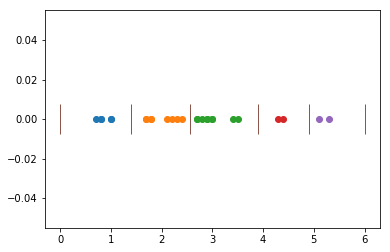

In [6]:
breaks = [0, 1.4, 2.55, 3.9, 4.9 ,6]

cantons_b = json.load(open("topojson/ch-cantons.topojson.json"))

m_rate = folium.Map([46.90, 8.50], zoom_start=8)
m_rate.choropleth(geo_data=cantons_b,
             threshold_scale=breaks,
             topojson="objects.cantons", 
             data=ur["rate"].reset_index(level=[0,1,2], drop=True), 
             fill_color='OrRd', 
             key_on="id",
             legend_name="Unemployment Rate")

plot_groups(ur, "rate", breaks)

Before displaying the map, we create a second one showing the rate difference between the *Swiss* and *Foreigners* categories, so that we can display the two maps consecutively.

For this second map, we chose to display the rates' differences in one map where darker colors mean bigger differences. The rate of unemployed foreigners being higher than the swiss' rate for all the cantons, this difference can be interpreted as "how higher is the foreigners' unemployment rate".

We choose different parameters ("breaks" or classification) for the construction of the second map. This is because the rate of the first one cannot be compared quantitatively with the rate **difference** of the second map.

We would have liked to add the same feature that is available in amstat.ch which is that when the cursor is on one of the canton/country there is a little pop-up indicating the country/canton's name and rate. Nevertheless, this feature is not yet available in the folium library. This would have made *the visualization intuitive and expressive*.

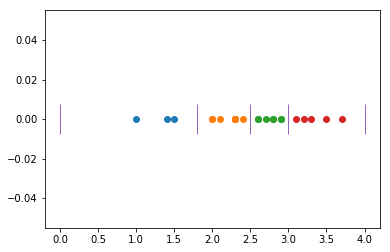

In [7]:
breaks = [0, 1.8, 2.5, 3, 4]

m_nat_diff = folium.Map([46.90, 8.50], zoom_start=8)     
m_nat_diff.choropleth(geo_data=cantons_b,
             threshold_scale=breaks,
             topojson="objects.cantons", 
             data=ur["rate_nat_diff"].reset_index(level=[0,1,2], drop=True), 
             fill_color='OrRd', 
             key_on="id",
             legend_name="Unemployment Rates difference")

plot_groups(ur, "rate_nat_diff", breaks)

## Switzerland's unemployment rate Maps

We now display the two maps, one after the other, and provide a succint analysis.
1. Unemployment rate per canton
2. Unemployment rate differences between swiss and foreigners




In [8]:
display(m_rate)
print("Map A: Unemployment rates by canton in Switzerland")
display(m_nat_diff)
print("Map B: Unemployment rate differences between Swiss and Foreign groups")

Map A: Unemployment rates by canton in Switzerland


Map B: Unemployment rate differences between Swiss and Foreign groups


## Maps Analysis

### 1. Unemployment rate per canton
We observe a tendency for the french-speaking part of switzerland to be more afftectd by unemployment. This is especially visible for Genève, Vaud, Neuchâtel and Jura, which have the highest rates in Switzerland. This illustrate how the job market in these cantons tend to be more tough, partly due to their accessibility (both in geographical and political terms) to worker from France.

### 2. Unemployment rate differences between swiss and foreigners
The second map shows an interesting kind of *reversed* pattern. Namely, German speaking part of switzerland tend to have larger differences than the french speaking part. This could comfort the previous comment, showing that cantons that are less open to foreign workers tend to have lower unemployment rates. For exemple, the *canton de Genève*, known for its openness to workers from France, clearly stands out from this vizualisation.

We underline that the message conveyed by these choropleth map are highly dependent on the thresholds, as discussed earlier. An unfortunate limitation of those is that we can only use a few bins for our data (6, in the Folium library if we don't want to rewrite the ```choropleth()``` methode). It would have been interesting to use a linear color gradient indexed by the rate and see wether this was a good vizualisation.

#### Different metrics can lead to different interpretations of the same data

In the amstat.ch FAQ (https://www.amstat.ch/v2/faq.jsp?lang=fr), it is indicated that the unemployment rate is computed by using the number of people that are looking for a job and that are not currently employed. This means that this map already satisfies the condition: "but this time don't count in your statistics people who already have a job and are looking for a new one" of the README.

To show that different parameters/categories can lead to different results, we computed the rate of people looking for a job in each canton. This group of people contains unemployed people and people that have a job but are looking for another one.

We computed the rate of people looking for a job by using the percentage of unemployed people, the number of unemployed people and the number of people looking for a job (using the cross multiplication rule or "règle de trois" in french).

We loose a bit of precision because the rate of unemployment is rounded to only one decimal.

Then, we use the same parameters that we used to construct the unemployment rate map. In fact, in contrary to the previous task, we want to compare the two rates and having different parameters ("breaks" or classification) might distort this comparison.

In [9]:
breaks = [0, 1.4, 2.55, 3.9, 4.9 ,6]

ur["rate_jobseek"] = ur["jobseek_c"]/(ur["unempl_c"]/(ur["rate"]/100))*100

cantons_b = json.load(open("topojson/ch-cantons.topojson.json"))

m_rate_dem = folium.Map([46.90, 8.50], zoom_start=8)
m_rate_dem.choropleth(geo_data=cantons_b,
             threshold_scale=breaks,
             topojson="objects.cantons", 
             data=ur["rate_jobseek"].reset_index(level=[0,1,2], drop=True), 
             fill_color='OrRd', 
             key_on="id",
             legend_name="Job Seekers Rate")

And draw the maps:
(we plot the unemployment rate map again to compare them easily)

In [10]:
display(m_rate)
display(m_rate_dem)

We observe that non-suprisingly the cantons with a high unemployment rate, also have a high percentage of people looking for a job. We can also notice that french and italian speaking people seems to be more inclined to change their job.

### Differences between age groups

We plot the unemployment rates per age groups in a bar plot.

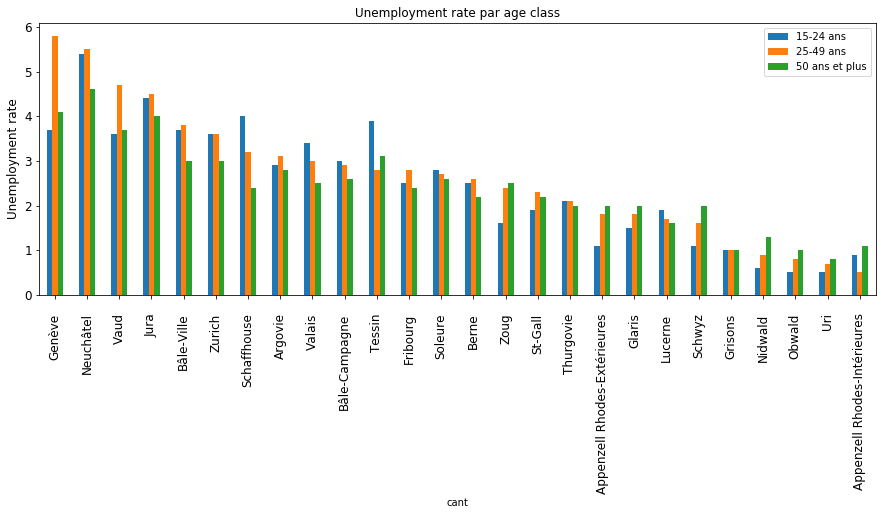

In [11]:
age_cat = ur_age.pivot_table(index="cant", columns="age_cat").sort_values(("rate","25-49 ans"), ascending=False)

f, ax = pp.subplots(figsize=(15, 5))
age_cat.plot(kind='bar', ax=ax, title="Unemployment rate par age class", legend=True, fontsize=12)
ax.set_ylabel("Unemployment rate", fontsize=12)
ax.tick_params(axis='x', which='major', pad=15)
ax.legend([a for r,a in age_cat.columns.values])
display(f)
pp.close(f)

We observe again a larger difference for the *canton de Genève* et *canton de Vaud*. It also looks like the variance within groups tend to increase with unemployment rate (more computation could comfirm that, but we restrict to visual analysis). Thus, rate difference between age groups could also be used as an indicator on the unemployment rate.

# Task 4: Röstigraben

By using the map "Unemployment rates per canton", we can almost see the Röstigraben without drawing it. In fact, the cantons that are completely in the french speaking part (Genève, Vaud, Neuchatel and almost Jura) clearly show a higher unemployment rate than the others. This would indicate a higher unemployment rate in the french part. Nevertheless, more granular statistics such as unemployment rates at the district level would be required to see if the röstigraben of unemployment rates is also visible inside the cantons that are crossed by the Röstigraben such as Valais and Fribourg.